# Visualizing the saliency maps

Once your classifier is trained you can visualize which pixels where the most relevant to classify an image as a certain label. This is what we call the *saliency maps*.

We will use the implementations of different saliency functions from the [deep-viz repository](https://github.com/experiencor/deep-viz-keras) by [experiencor](https://github.com/experiencor) which allows the visualization of saliency maps for keras models.

**Remarks:** For some reason the code seems to fail when using the `Xception` architecture. `ResNet` for example, works fine though.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2021-10-26_Lab_All_Copas_All_reg'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=True)

W1028 12:10:47.210659 140361186703168 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1028 12:10:47.211918 140361186703168 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1028 12:10:47.213122 140361186703168 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Now you can select a file in your computer in which to visualize the saliency maps. 
Possible visualizations include:
* [Vanila gradient](https://arxiv.org/abs/1312.6034)
* [Guided backprop](https://arxiv.org/abs/1412.6806)
* [Integrated gradients](https://arxiv.org/abs/1703.01365)
* [Visual backprop](https://arxiv.org/abs/1611.05418)

Each of them is accompanied with the corresponding [smoothgrad](https://arxiv.org/abs/1706.03825) version, which improves on any baseline method by adding random noise.

In [ ]:
cd ..

[1/3] GradientSaliency
[2/3] GuidedBackprop
[3/3] IntegratedGradients
1/1 [==============================] - 1s 1s/step
Predicted value:
213.77545166015625


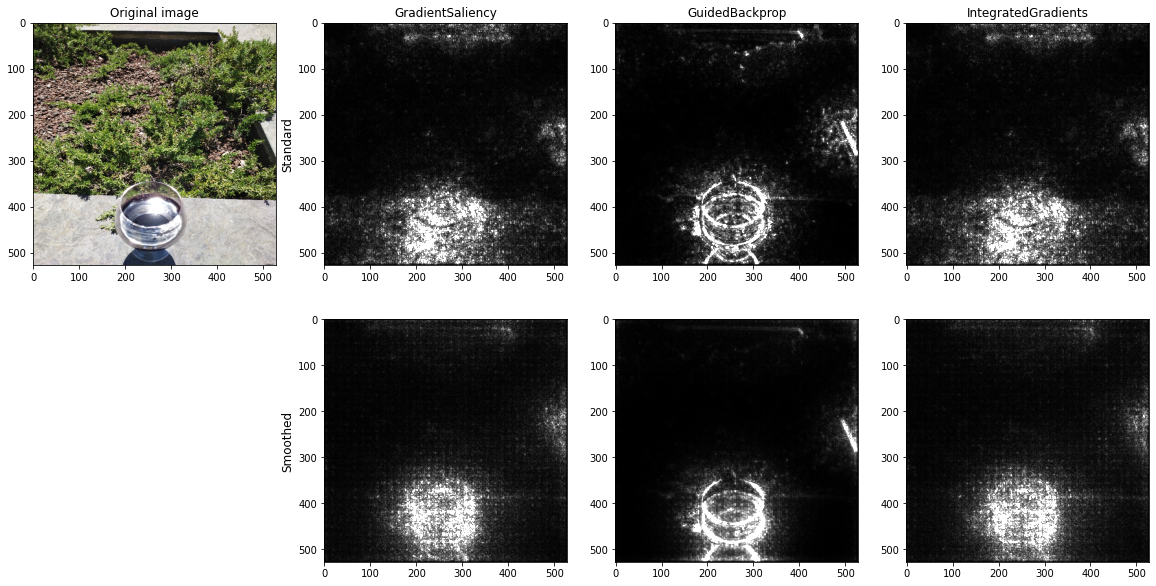

In [10]:
FILEPATH = '/srv/datos/Laboratorio/La Rioja/CIBIR/copa Burdeos/Est_Rio_C_Bur_225_nd_ext_nd_nd_ce_sup.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/3] GradientSaliency
[2/3] GuidedBackprop
[3/3] IntegratedGradients
1/1 [==============================] - 1s 1s/step
Predicted value:
139.29498291015625


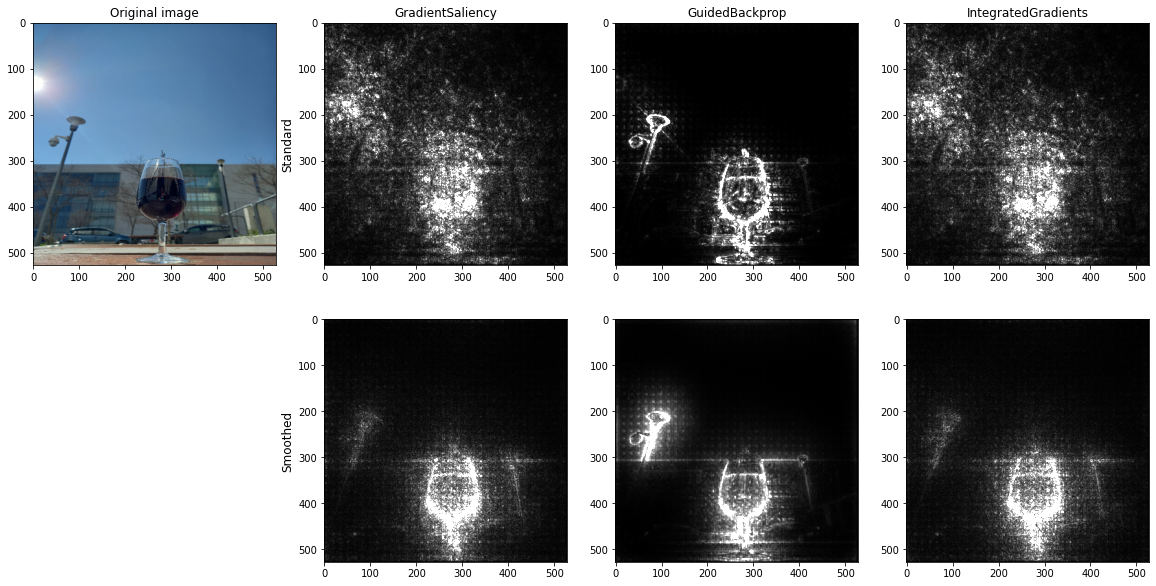

In [8]:
FILEPATH = '/srv/datos/Laboratorio/Madrid/copa Cata/Exterior/Est_Mad_J_Cata_150_nd_ext_nd_nd_al_inf.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/3] GradientSaliency
[2/3] GuidedBackprop
[3/3] IntegratedGradients
1/1 [==============================] - 1s 1s/step
Predicted value:
200.8003692626953


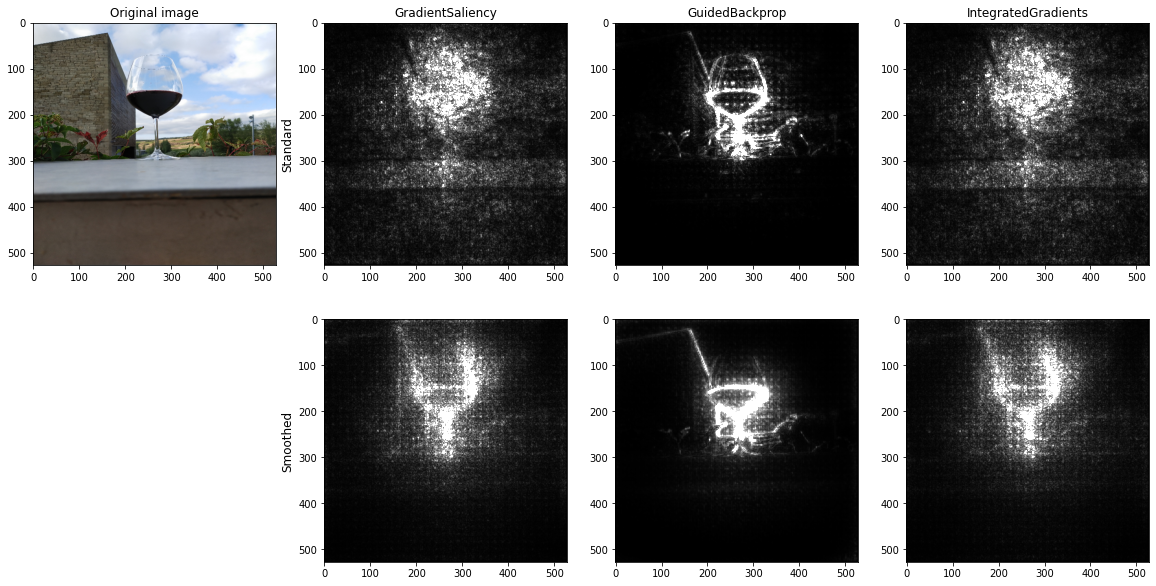

In [9]:
FILEPATH = '/srv/datos/Laboratorio/La Rioja/ICVV/Copa Borgoña/Est_Rio_R_Bor_200_nd_ext_nd_nd_al_inf.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/3] GradientSaliency
[2/3] GuidedBackprop
[3/3] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
67.11580657958984


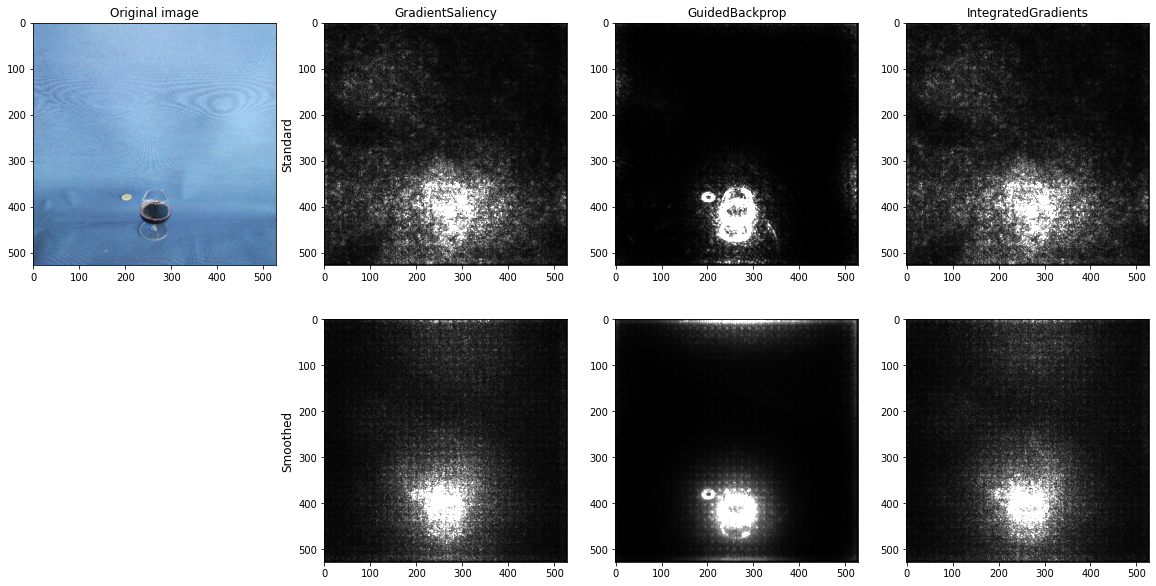

In [7]:
FILEPATH = '/srv/datos/Laboratorio/La Rioja/ICVV/Copa Cata/Est_Rio_R_Cata_75_nd_f_az_con_me_sup.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/3] GradientSaliency
[2/3] GuidedBackprop
[3/3] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
192.14561462402344


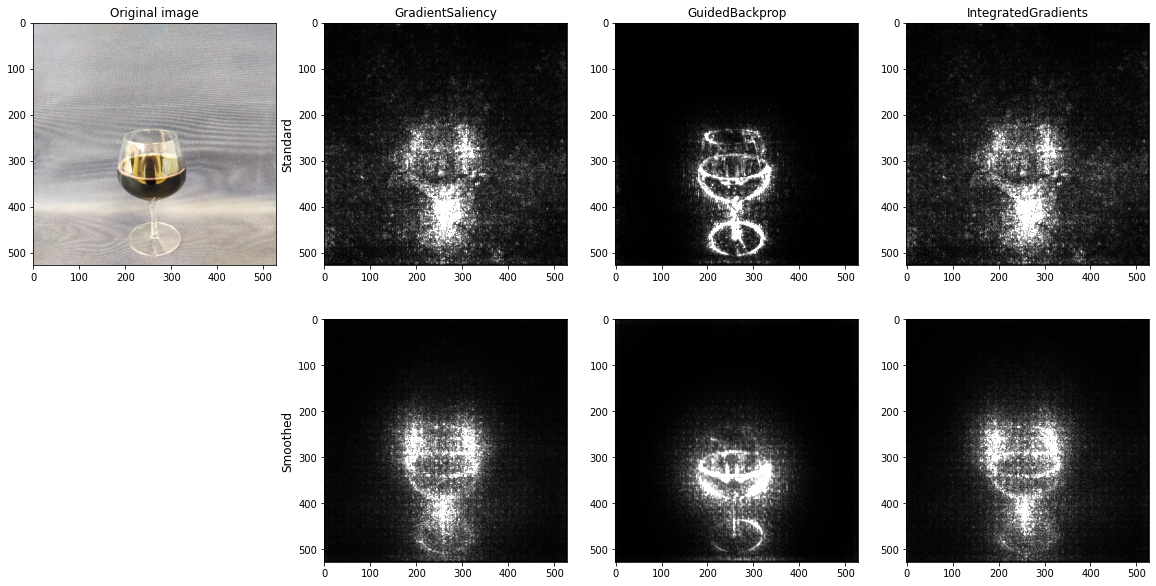

In [11]:
FILEPATH = '/srv/datos/Laboratorio/La Rioja/CIBIR/copa Chardonnay/Est_Rio_C_Char_175_nd_nf_az_sin_me_sup1.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

In [12]:
'''
Round a number to the closer 25th (i.e. 0, 25, 50, 75, etc.)

It is important to note that x.5 will be rounded to x instead of x+1 in the current 3.6.8 Python version.
For more details see https://stackoverflow.com/questions/10825926/python-3-x-rounding-behavior
'''

def myround(x, base=25):
    return round(base * round(float(x)/base))

In [13]:
# Load back the predictions
SPLIT_NAME='test'
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)
    
# save images that are wrong predicted in a list,
# to see if they share a pattern
wrong_predictions=[]
for i in range(len(pred_dict['true_value'])):
    if myround(pred_dict['pred_value'][i])!=pred_dict['true_value'][i]:
        wrong_predictions.append(pred_dict['filenames'][i])
        
# extract values of angle, plane and background in wrong predicted images
w_angles=[]
w_planes=[]
w_back=[]
w_vol=[]
# w_glass=[]
for file in wrong_predictions:
    l=file.split('_')
    w_planes.append(l[-2])
    w_angles.append(l[-1].split('.')[0])
    w_back.append(l[-4])
    w_vol.append(int(l[4]))
#     w_glass.append(l[3])

# extract values of angle, plane and background in all images
angles=[]
planes=[]
back=[]
vol=[]
# glass=[]
for file in pred_dict['filenames']:
    l=file.split('_')
    planes.append(l[-2])
    angles.append(l[-1].split('.')[0])
    back.append(l[-4])
    vol.append(int(l[4]))
#     glass.append(l[3])
    if l[-1].split('.')[0]=='al':
        print(file)

# get counts
from collections import Counter
c_planes=Counter(planes)
c_w_planes=Counter(w_planes)
c_angles=Counter(angles)
c_w_angles=Counter(w_angles)
c_back=Counter(back)
c_w_back=Counter(w_back)
c_vol=Counter(vol)
c_w_vol=Counter(w_vol)
# c_glass=Counter(glass)
# c_w_glass=Counter(w_glass)

# create dataframes
import pandas as pd
df1 = pd.DataFrame.from_records(list(dict(c_planes).items()), columns=['plane','total'])
df2 = pd.DataFrame.from_records(list(dict(c_w_planes).items()), columns=['plane','wrong'])
planes=pd.merge(df1, df2, on='plane', how='outer')
df1 = pd.DataFrame.from_records(list(dict(c_angles).items()), columns=['angle','total'])
df2 = pd.DataFrame.from_records(list(dict(c_w_angles).items()), columns=['angle','wrong'])
angles=pd.merge(df1, df2, on='angle', how='outer')
df1 = pd.DataFrame.from_records(list(dict(c_back).items()), columns=['background','total'])
df2 = pd.DataFrame.from_records(list(dict(c_w_back).items()), columns=['background','wrong'])
backgrounds=pd.merge(df1, df2, on='background', how='outer')
df1 = pd.DataFrame.from_records(list(dict(c_vol).items()), columns=['volume','total'])
df2 = pd.DataFrame.from_records(list(dict(c_w_vol).items()), columns=['volume','wrong'])
volumes=pd.merge(df1, df2, on='volume', how='outer')
# df1 = pd.DataFrame.from_records(list(dict(c_glass).items()), columns=['glass','total'])
# df2 = pd.DataFrame.from_records(list(dict(c_w_glass).items()), columns=['glass','wrong'])
# glasses=pd.merge(df1, df2, on='glass', how='outer')

planes['relative']=planes['wrong']/planes['total']
angles['relative']=angles['wrong']/angles['total']
backgrounds['relative']=backgrounds['wrong']/backgrounds['total']
volumes['relative']=volumes['wrong']/volumes['total']
# glasses['relative']=glasses['wrong']/glasses['total']

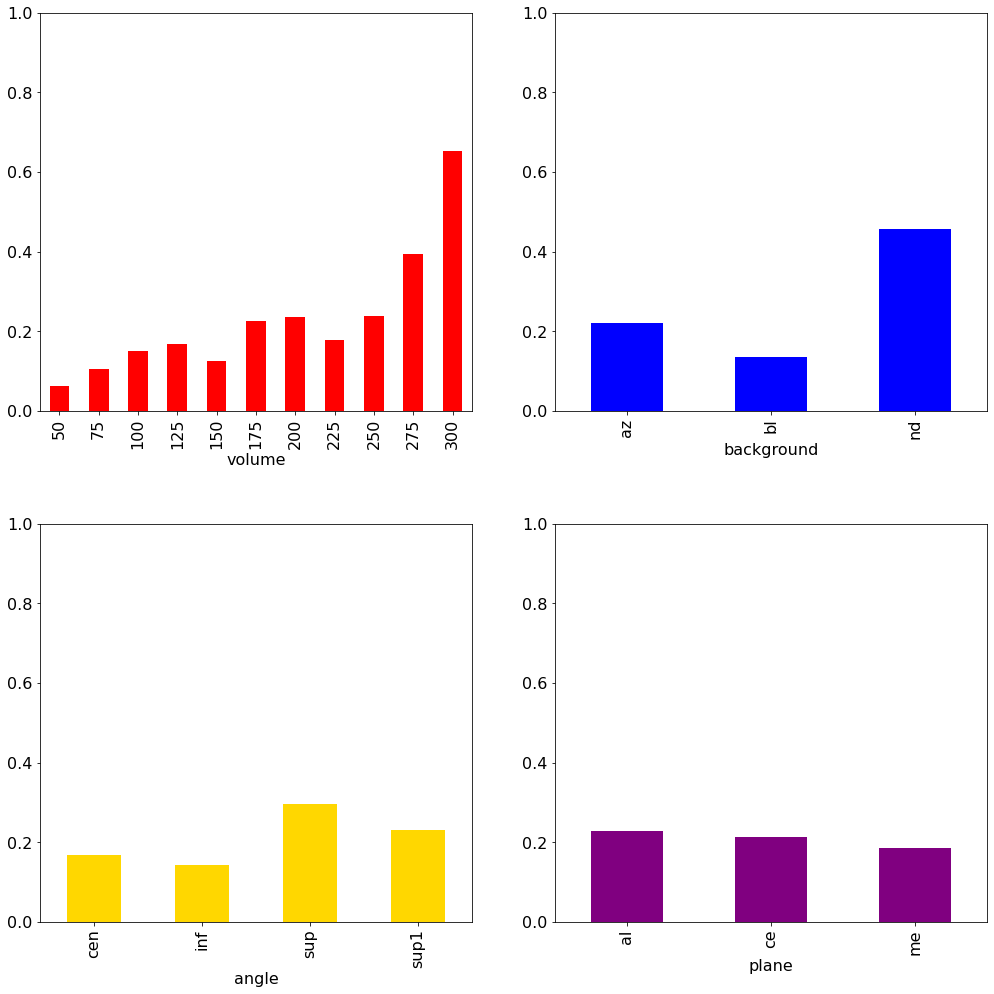

In [14]:
import matplotlib.pyplot as plt

parameters = {'axes.labelsize': 16,
          'axes.titlesize': 18,
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'legend.fontsize':16}
plt.rcParams.update(parameters)

#define number of rows and columns for subplots
fig, axes = plt.subplots(2,2, figsize=(15,15))

volumes.sort_values(by='volume',ascending=True).plot.bar(x='volume', y='relative', ylim=[0, 1], ax=axes[0,0], color=['red'], legend=None)
backgrounds.sort_values(by='background', ascending=True).plot.bar(x='background', y='relative', ylim=[0, 1], ax=axes[0,1], color=['blue'], legend=None)
# glasses.sort_values(by='glass',ascending=True).plot.bar(x='glass', y='relative', ylim=[0, 1], ax=axes[0,1], color=['blue'], legend=None)
angles.sort_values(by='angle',ascending=True).plot.bar(x='angle', y='relative', ylim=[0, 1], ax=axes[1,0], color=['gold'], legend=None)
planes.sort_values(by='plane',ascending=True).plot.bar(x='plane', y='relative', ylim=[0, 1], ax=axes[1,1], color=['purple'], legend=None)
fig.tight_layout(pad=5.0)

# plt.savefig('/srv/image-results/Madrid_copas_All_statistics.jpg')
plt.show()

In [15]:
len(wrong_predictions)

322

In [13]:
# wrong_predictions